In [381]:
from pathlib import Path
import pandas as pd 
import numpy as np
from plotnine import * 
import datar.all

In [344]:
folder = Path('../smallTseq/nya_gentools/results/')
unwanted_files = ['coldata', 'de_genes']
file_list = sorted([file for file in folder.iterdir() if file.suffix == '.csv' and file.stem not in unwanted_files])
names = [file.stem for file in file_list]

df_list = [pd.read_csv(file).assign(program=file.stem) for file in file_list]
total_df = pd.concat(df_list)
total_df['name'] = [x.split('_')[0] for x in total_df['name']]

raw = (total_df
    .groupby('name')
    .max()
    .reset_index()
    .assign(program='raw')
    .drop('post_filtering', axis=1)
    .rename({'pre_filtering': 'value'}, axis=1))

total_df = (total_df
    .drop('pre_filtering', axis=1)
    .rename({'post_filtering':'value'}, axis=1))

plot = pd.concat([total_df, raw], ignore_index=True)



In [354]:
fig = (plot >> 
       mutate(program = fct_reorder(f.program, f.value)) >>
       ggplot(aes('program', 'value', fill='program')) +
       geom_col() + facet_wrap('name') + 
       coord_flip() +
       theme_seaborn() +
       theme(axis_text_x = element_text(angle = 90)) +
       labs(x='', 
           y='Number of reads',
           title='Reads filtered by each program'))
    





/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: preprocessed.pdf


In [355]:
def plot_col_all(config: str) -> None:
    '''Creates a facet plot over all samples and the relationship between reads after each processing step'''
    
    folder = CreateFolders(config)
    unwanted_files = ['coldata', 'de_genes']
    file_list = sorted([file for file in folder.results.iterdir() if file.suffix == '.csv' and file.stem not in unwanted_files])
    
    df_list = [pd.read_csv(file).assign(program=file.stem) for file in file_list]
    total_df = pd.concat(df_list)
    total_df['name'] = [x.split('_')[0] for x in total_df['name']]
    
    raw = (total_df
    .groupby('name')
    .max()
    .reset_index()
    .assign(program='raw')
    .drop('post_filtering', axis=1)
    .rename({'pre_filtering': 'value'}, axis=1))

    total_df = (total_df
    .drop('pre_filtering', axis=1)
    .rename({'post_filtering':'value'}, axis=1))

    plot = pd.concat([total_df, raw], ignore_index=True)
    
    fig = (plot >> 
       mutate(program = fct_reorder(f.program, f.value)) >>
       ggplot(aes('program', 'value', fill='program')) +
       geom_col() + facet_wrap('name') + 
       coord_flip() +
       theme_seaborn() +
       theme(axis_text_x = element_text(angle = 90)) +
       labs(x='', 
           y='Number of reads',
           title='Reads filtered by each program'))
    
    fig_save_name = folder.results / 'processed_files_all.pdf'
    plot_save_name = folder.results / 'concatenated_processing_file.csv'
    plot.to_csv(plot_save_name, index=False)
    
    


/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


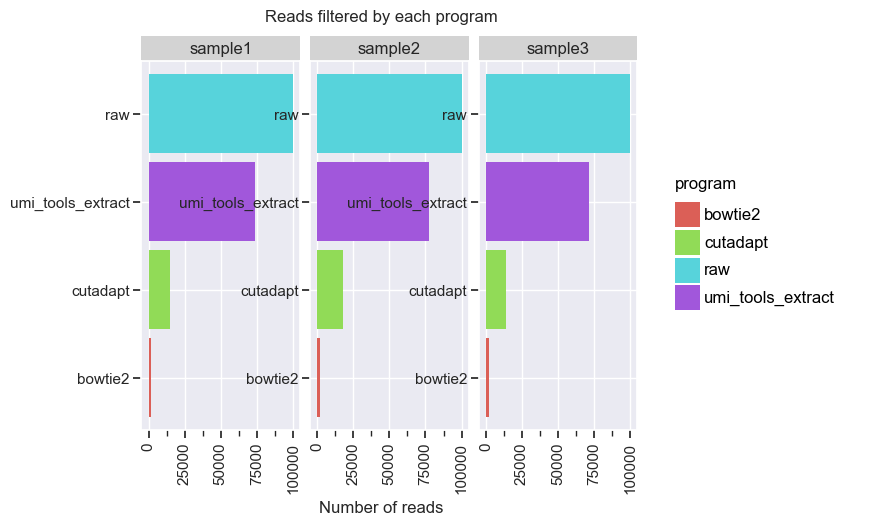

<ggplot: (379418950)>

In [424]:


fig = (plot >> 
       ggplot(aes('reorder(program, value)', 'value', fill='program')) +
       geom_col() + facet_wrap('name', scales='free') + 
       coord_flip() +
       theme_seaborn() +
       theme(axis_text_x = element_text(angle = 90)) +
       labs(x='', 
           y='Number of reads',
           title='Reads filtered by each program'))

fig

In [416]:
import re 

log = '../SRR3495859_umi_tools_extract.log'
with open(log, 'r') as f:
    log_file = f.read()

pattern_pre = re.compile(r'Total reads processed: +([\d,]+)')
pattern_post = re.compile(r'Reads written \(passing filters\): +([\d,]+)')

match_pre = re.findall(pattern_pre, log_file)

match_pre
match_post = re.findall(pattern_post, log_file)

In [419]:
test = 'SRRR88888'
test.split('_')[0]

'SRRR88888'